In [1]:
import re
import optuna
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_score, learning_curve, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from data_manipulations import *

/home/tibo/.local/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_features = pl.read_parquet('train_features.parquet')
train_targets = pl.read_parquet('train_targets.parquet')
test_features = pl.read_parquet('test_features.parquet')
test_targets = pl.read_parquet('test_targets.parquet')

data = prepare_data_for_ml(
    train_features, train_targets, test_features, test_targets,
)

In [3]:
# def restrict(frame, heads=(25, 20)):
#     keys = frame.columns[:2]
#     temp = join_many((
#         frame.select(keys[0]).unique().sort(by=keys[0]).head(heads[0]),
#         frame.select(keys[1]).unique().sort(by=keys[1]).head(heads[1]),
#     ), how='cross')
#     return frame.join(temp, on=keys)

# train_features = restrict(train_features)
# train_targets = restrict(train_targets)
# test_features = restrict(test_features)
# test_targets = restrict(test_targets)

# data = prepare_data_for_ml(train_features, train_targets, test_features, test_targets)
# data['train_features_rect'].shape, data['train_targets_rect'].shape

# Exploration

In [4]:
%%time

n_trials = 50
progress_bar = tqdm(total=n_trials)

def objective(trial):
    alpha = trial.suggest_float('alpha', 1e-5, 1e2, log=True)
    l1_ratio = trial.suggest_float('l1_ratio', 0, 1)
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'adaptive', 'invscaling'])
    is_std_scaled = trial.suggest_categorical('is_std_scaled', [True, False])

    model = MultiOutputRegressor(SGDRegressor(
        penalty='elasticnet',  # 'l2'
        alpha=alpha,  # 0.001
        l1_ratio=l1_ratio,  # 0.15
        fit_intercept=fit_intercept,  # True
        max_iter=2000,  # 1000
        random_state=0,  # None
        learning_rate=learning_rate,  # 'invscaling'
        early_stopping=True,  # False
    ))
    if is_std_scaled:
        model = make_pipeline(StandardScaler(), model)

    score = cross_val_score(
        model,
        data['train_features_rect'].to_numpy(),
        data['train_targets_rect'].to_numpy(),
        cv=5,
        scoring=scoring,
        n_jobs=-1,
    )

    progress_bar.update(1)
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n_trials)

  8%|▊         | 4/50 [00:11<02:01,  2.64s/it][I 2025-04-20 21:03:39,640] Trial 3 finished with value: 0.0 and parameters: {'alpha': 0.03424738121030133, 'l1_ratio': 0.6537150200723135, 'fit_intercept': False, 'learning_rate': 'constant', 'is_std_scaled': True}. Best is trial 1 with value: 0.6594979530736873.
/home/tibo/.local/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/tibo/.local/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/tibo/.local/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to imp

CPU times: user 2.06 s, sys: 616 ms, total: 2.67 s
Wall time: 7min 18s


In [5]:
prefix = r'^params_'
cv_results = pl.DataFrame(study.trials_dataframe())
cv_results = (
    cv_results
    .rename({
        col: re.sub(prefix, '', col)
        for col in cv_results.columns
    })
)

{'fit_intercept': False, 'learning_rate': 'optimal', 'is_std_scaled': True}


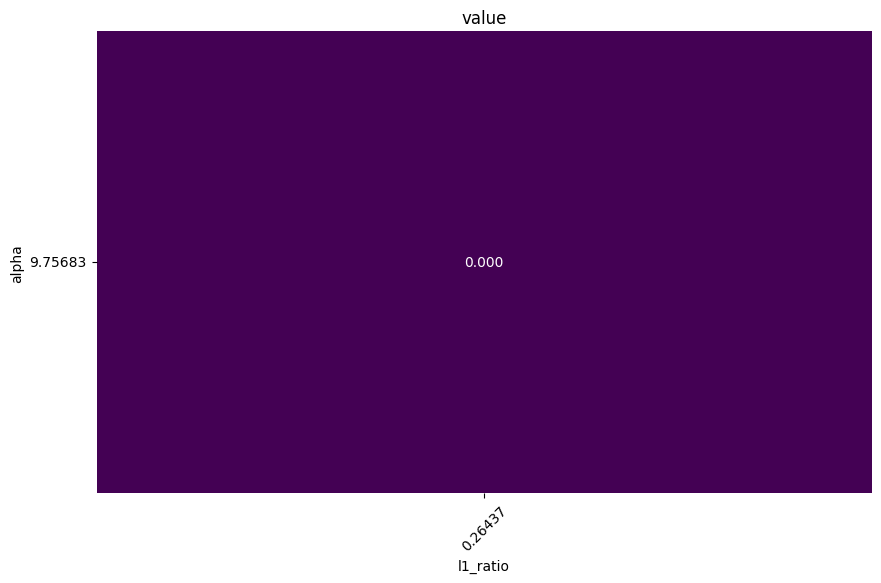

{'fit_intercept': False, 'learning_rate': 'constant', 'is_std_scaled': True}


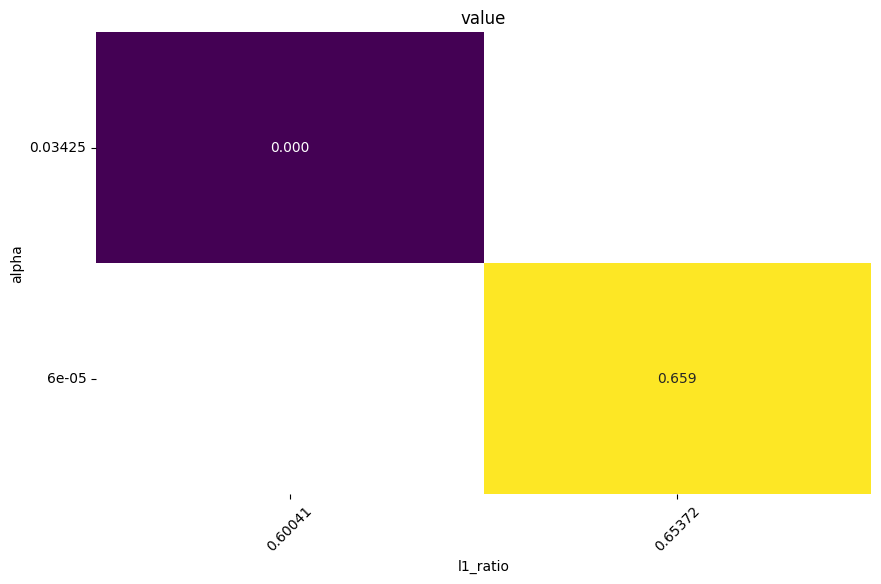

{'fit_intercept': False, 'learning_rate': 'constant', 'is_std_scaled': False}


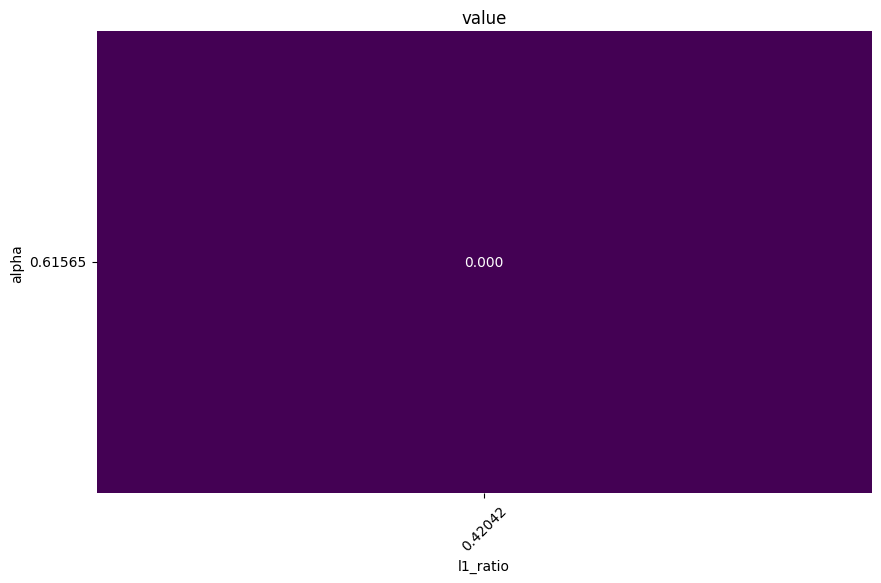

{'fit_intercept': True, 'learning_rate': 'optimal', 'is_std_scaled': False}


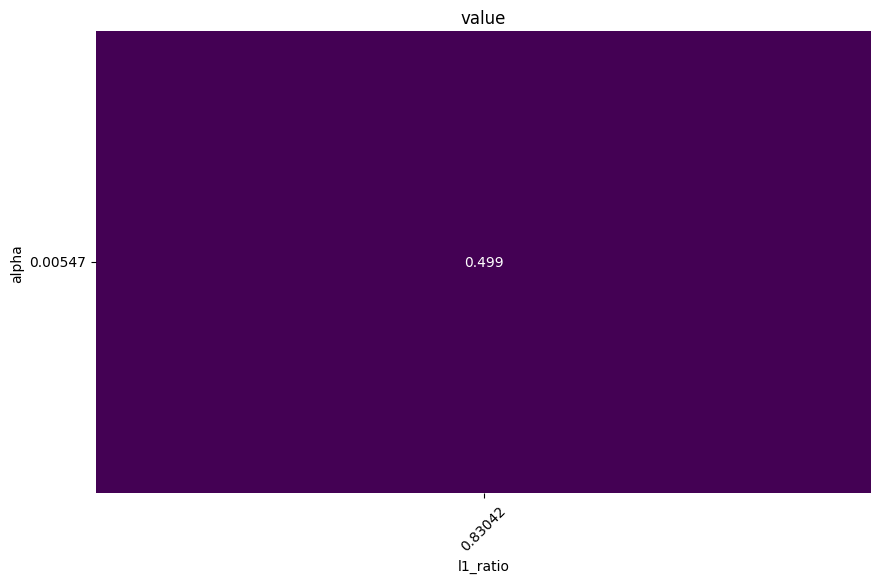

{'fit_intercept': False, 'learning_rate': 'optimal', 'is_std_scaled': False}


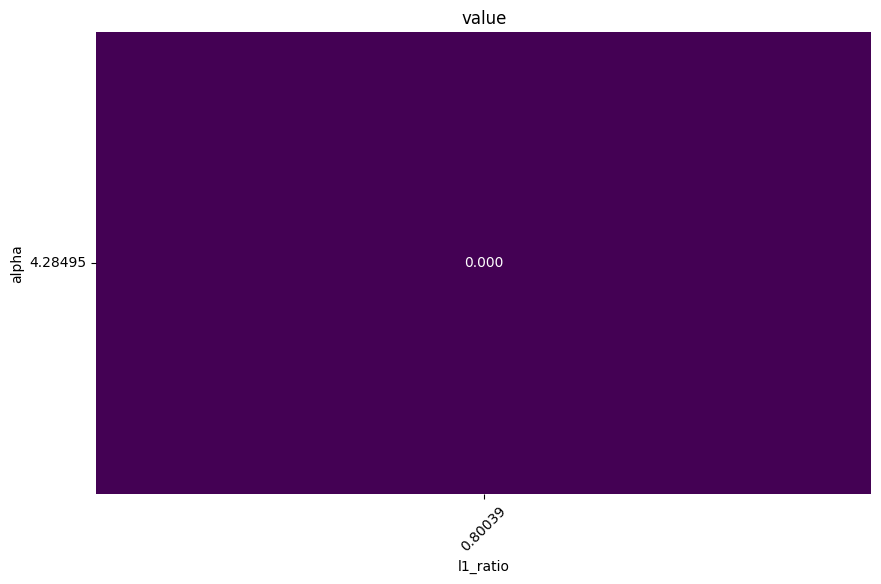

{'fit_intercept': True, 'learning_rate': 'adaptive', 'is_std_scaled': False}


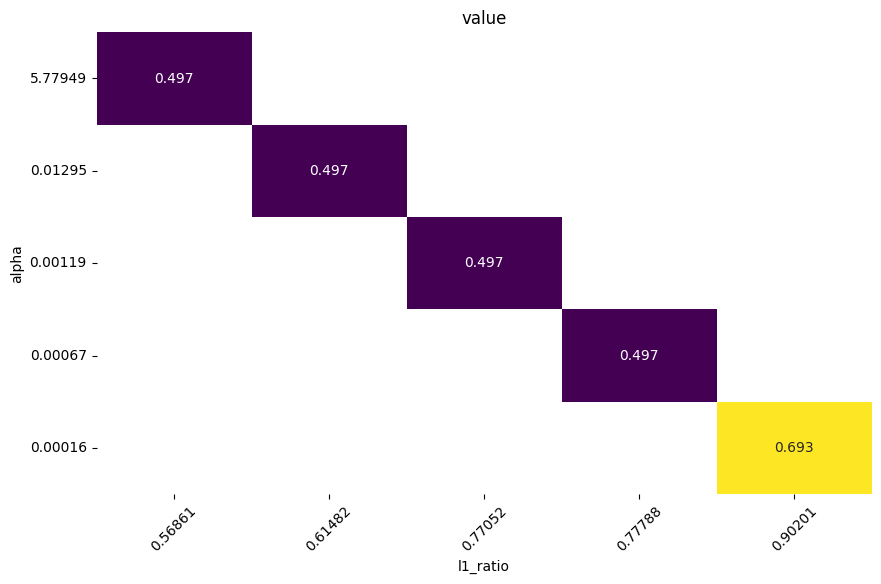

{'fit_intercept': False, 'learning_rate': 'adaptive', 'is_std_scaled': False}


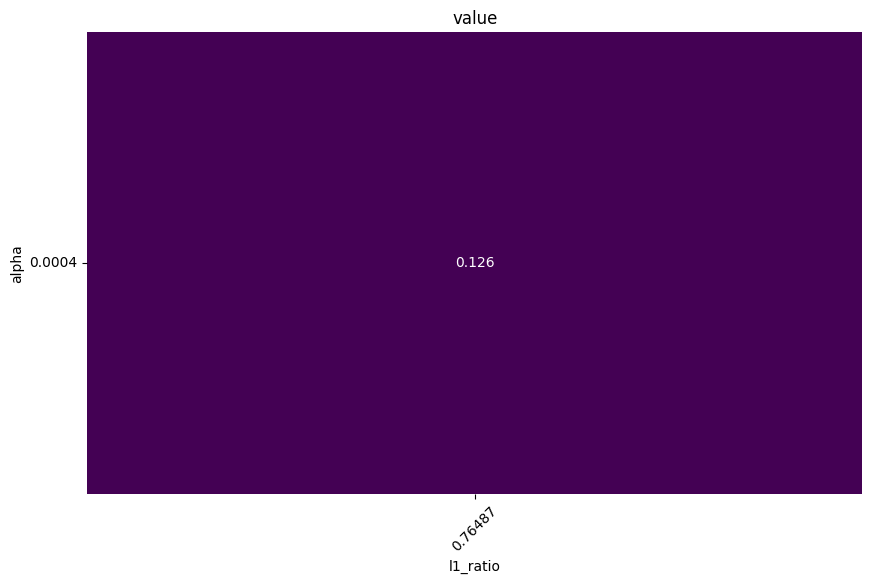

{'fit_intercept': True, 'learning_rate': 'optimal', 'is_std_scaled': True}


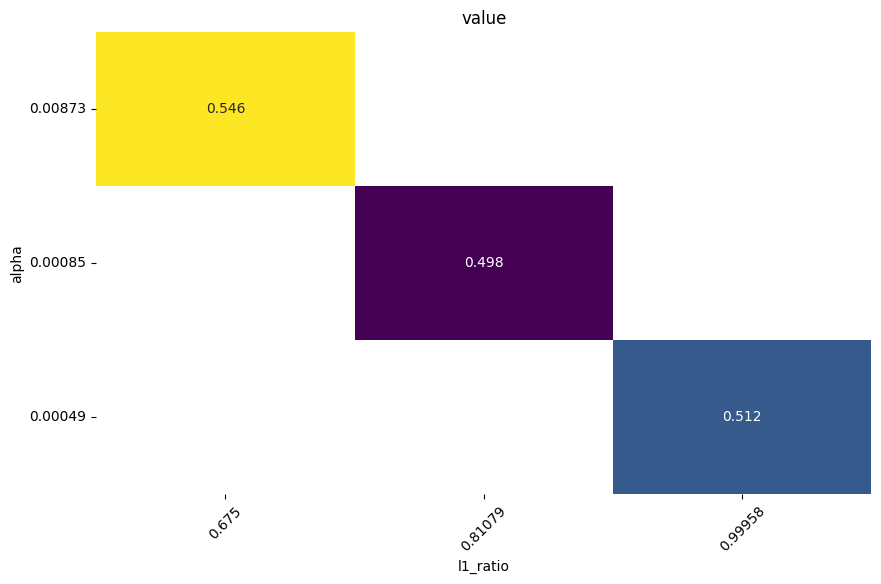

{'fit_intercept': True, 'learning_rate': 'constant', 'is_std_scaled': False}


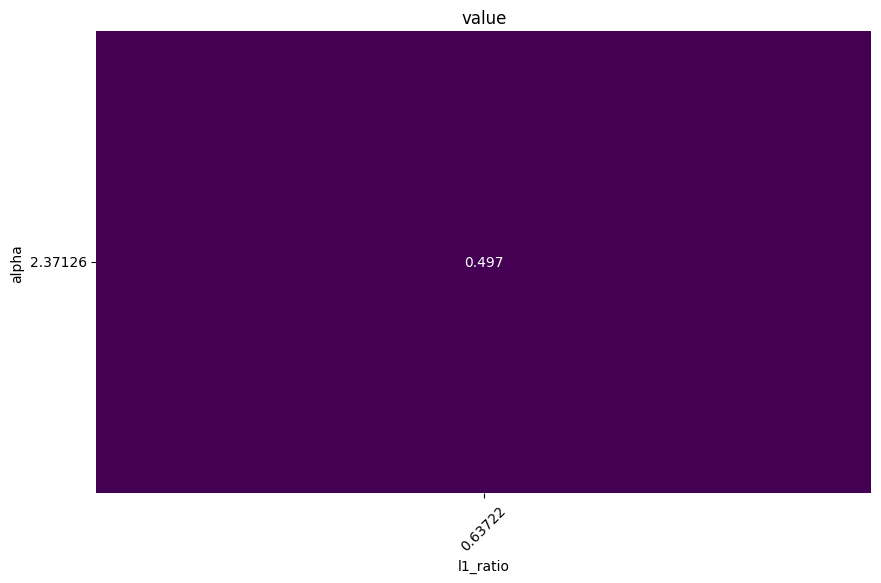

{'fit_intercept': False, 'learning_rate': 'invscaling', 'is_std_scaled': True}


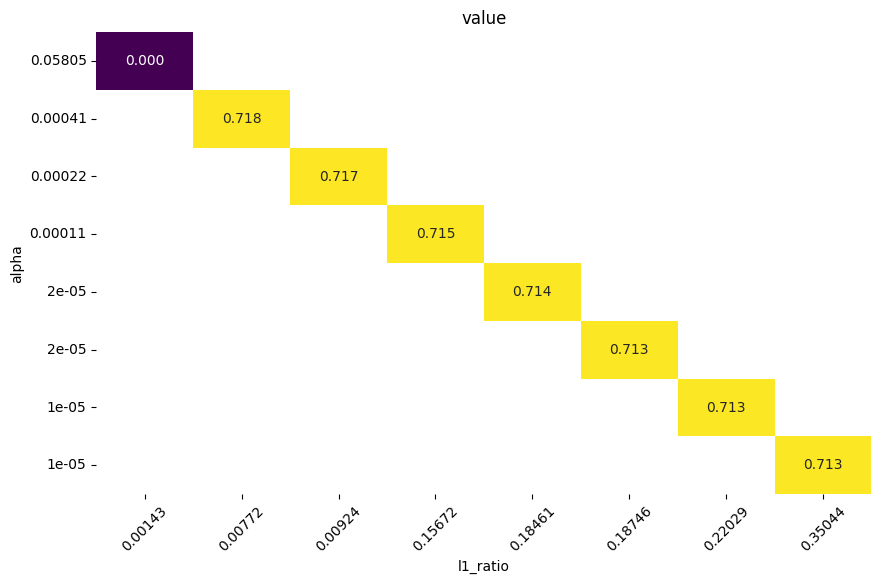

{'fit_intercept': True, 'learning_rate': 'invscaling', 'is_std_scaled': True}


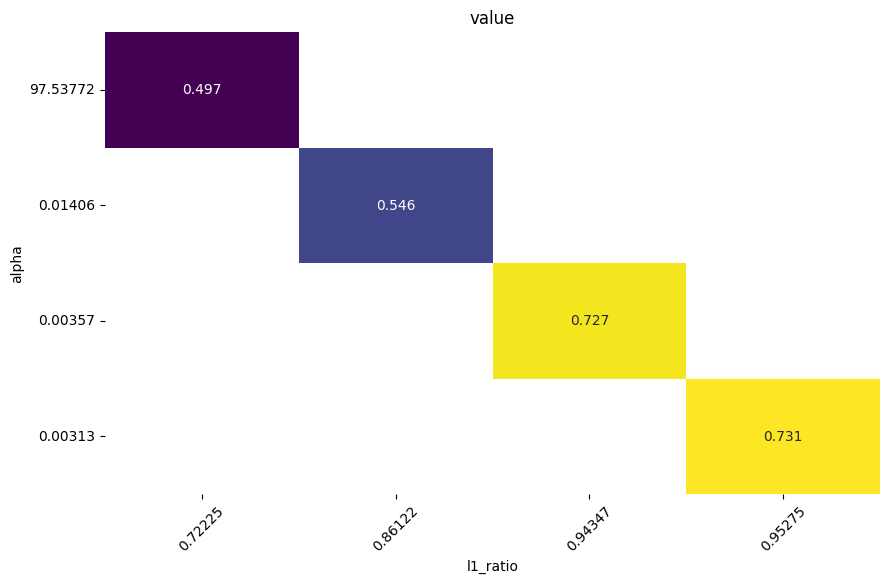

{'fit_intercept': True, 'learning_rate': 'adaptive', 'is_std_scaled': True}


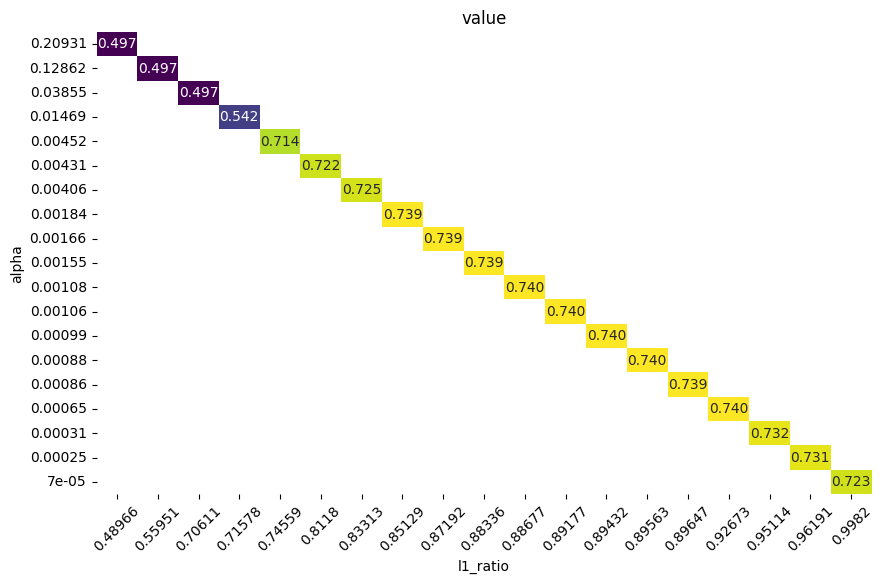

{'fit_intercept': True, 'learning_rate': 'constant', 'is_std_scaled': True}


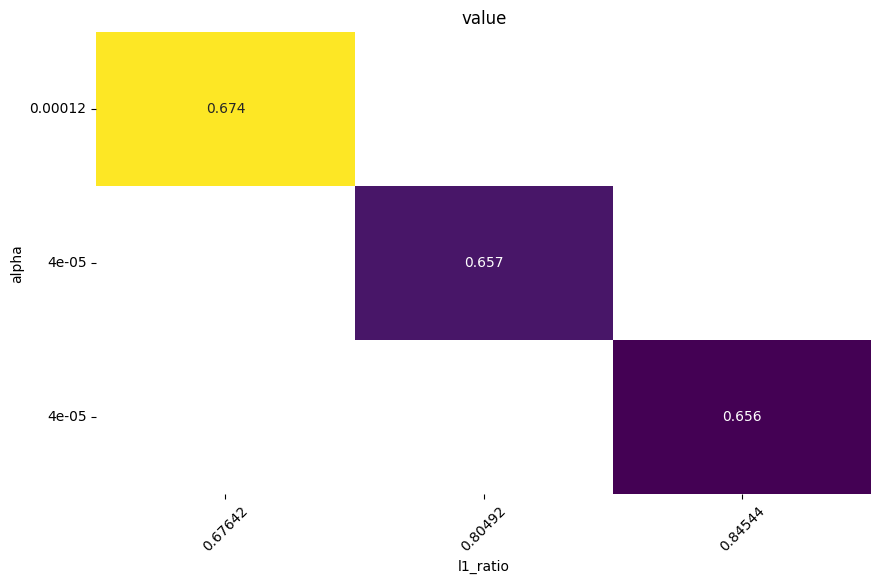

In [6]:
discrete = ['fit_intercept', 'learning_rate', 'is_std_scaled']
continuous = ['alpha', 'l1_ratio']
parts = cv_results.partition_by(discrete, as_dict=True)
for key, part in parts.items():
    print(dict(zip(discrete, key)))
    heatmap_part(part, continuous, 'value')
    plt.show()

In [7]:
best = cv_results.filter(pl.col('value') == pl.col('value').max()).select(discrete + continuous).to_dicts()[0]
best

{'fit_intercept': True,
 'learning_rate': 'adaptive',
 'is_std_scaled': True,
 'alpha': 0.0010604491781096273,
 'l1_ratio': 0.8964741358720928}

# Stability

In [11]:
param_grid = {
    'multioutputregressor__estimator__alpha': np.logspace(-5, -2, 10),
    'multioutputregressor__estimator__l1_ratio': np.logspace(-1, 0, 10),
}
model = MultiOutputRegressor(SGDRegressor(
    penalty='elasticnet',  # 'l2'
    alpha=0.001,  # 0.001
    l1_ratio=0.15,  # 0.15
    fit_intercept=True,  # True
    max_iter=2000,  # 1000
    random_state=0,  # None
    learning_rate='adaptive',  # 'invscaling'
    early_stopping=True,  # False
))
model = make_pipeline(StandardScaler(), model)

In [12]:
%%time
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    n_jobs=-1,
    verbose=2,
)
_ = grid.fit(
    data['train_features_rect'].to_numpy(),
    data['train_targets_rect'].to_numpy(),
)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: user 7.85 s, sys: 594 ms, total: 8.45 s
Wall time: 6min 55s
[CV] END multioutputregressor__estimator__alpha=1e-05, multioutputregressor__estimator__l1_ratio=0.1291549665014884; total time=  11.3s
[CV] END multioutputregressor__estimator__alpha=1e-05, multioutputregressor__estimator__l1_ratio=0.21544346900318834; total time=  12.8s
[CV] END multioutputregressor__estimator__alpha=1e-05, multioutputregressor__estimator__l1_ratio=0.46415888336127786; total time=  13.5s
[CV] END multioutputregressor__estimator__alpha=2.1544346900318823e-05, multioutputregressor__estimator__l1_ratio=0.1; total time=  13.3s
[CV] END multioutputregressor__estimator__alpha=2.1544346900318823e-05, multioutputregressor__estimator__l1_ratio=0.21544346900318834; total time=  13.4s
[CV] END multioutputregressor__estimator__alpha=2.1544346900318823e-05, multioutputregressor__estimator__l1_ratio=0.46415888336127786; total time=  15.7s
[CV] END m

In [13]:
cv_results = grid.cv_results_
cv_results = pl.concat([
    pl.DataFrame({k: v for k, v in cv_results.items() if k != 'params'}),
    # pl.DataFrame(cv_results['params']),
], how='horizontal')

prefix = r'^param_'
cv_results = (
    cv_results
    .rename({
        col: re.sub(prefix, '', col)
        for col in cv_results.columns
    })
)

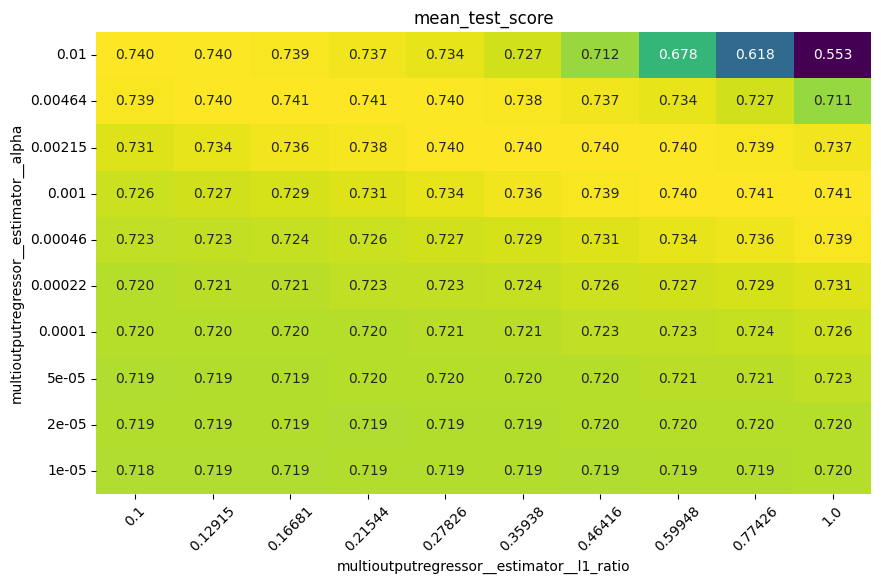

In [14]:
continuous = ['multioutputregressor__estimator__alpha', 'multioutputregressor__estimator__l1_ratio']
heatmap_part(cv_results, continuous, 'mean_test_score')

In [15]:
cv_results.filter(pl.col('mean_test_score') == pl.col('mean_test_score').max()).select(continuous).to_dicts()[0]

{'multioutputregressor__estimator__alpha': 0.004641588833612777,
 'multioutputregressor__estimator__l1_ratio': 0.21544346900318834}

# Learning curve

In [16]:
model = MultiOutputRegressor(SGDRegressor(
    penalty='elasticnet',  # 'l2'
    alpha=0.005,  # 0.001
    l1_ratio=0.2,  # 0.15
    fit_intercept=True,  # True
    max_iter=2000,  # 1000
    random_state=0,  # None
    learning_rate='adaptive',  # 'invscaling'
    early_stopping=True,  # False
))
model = make_pipeline(StandardScaler(), model)

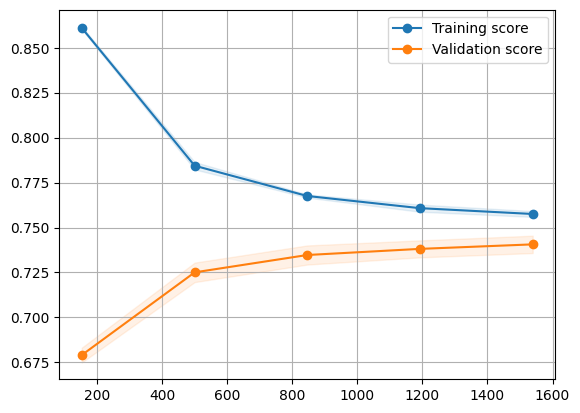

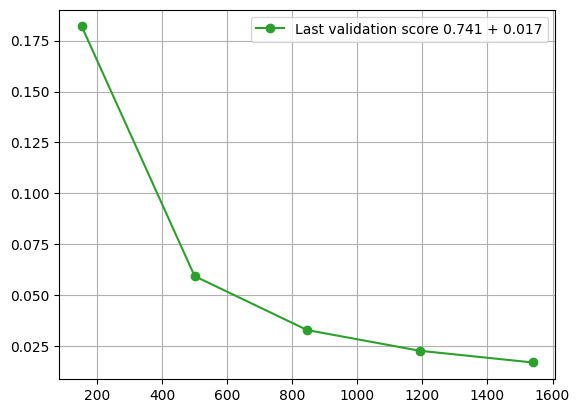

CPU times: user 227 ms, sys: 231 ms, total: 458 ms
Wall time: 16 s


In [17]:
%%time

train_sizes, train_scores, test_scores = learning_curve(
    model,
    data['train_features_rect'].to_numpy(),
    data['train_targets_rect'].to_numpy(),
    cv=5,
    scoring=scoring,
    n_jobs=-1,
)
plot_learning_curve(train_sizes, train_scores, test_scores)

# Score on test

In [18]:
fitted_model, preds = fit_predict_sklearn_model(
    train_features, train_targets, test_features, test_targets,
    model,
)
join_truth_and_score(preds, data['test_days'], test_targets)

0.7359493384917943